In [1]:
import os
import pandas as pd

RAV = "D:/FPT/DPL/project3/ravdess" 

dir_list = os.listdir(RAV)
dir_list.sort()

emotion = []
path = []

emotion_map = {
    1: 'neutral',
    2: 'calm',
    3: 'happy',
    4: 'sad',
    5: 'angry',
    6: 'fear',
    7: 'disgust',
    8: 'surprise'
}

for actor_folder in dir_list:
    actor_path = os.path.join(RAV, actor_folder)
    if not os.path.isdir(actor_path):
        continue 
    files = os.listdir(actor_path)
    for f in files:
        if not f.endswith('.wav'):
            continue
        parts = f.split('.')[0].split('-')
        if len(parts) < 3:
            continue 
        emotion_id = int(parts[2])
        emotion.append(emotion_map[emotion_id])
        path.append(os.path.join(RAV, actor_folder, f))

RAV_df = pd.DataFrame({
    'emotion': emotion,
    'path': path
})

print(RAV_df['emotion'].value_counts())


emotion
calm        192
happy       192
sad         192
angry       192
disgust     192
fear        192
surprise    192
neutral      96
Name: count, dtype: int64


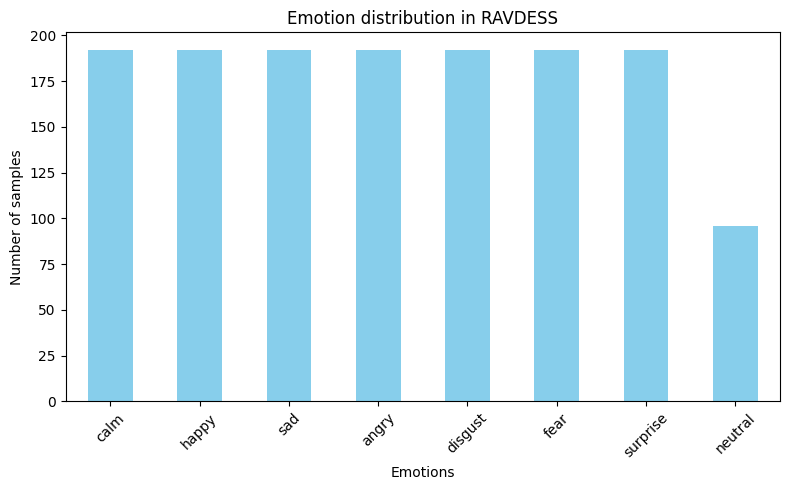

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
RAV_df['emotion'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Emotion distribution in RAVDESS')
plt.xlabel('Emotions')
plt.ylabel('Number of samples')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Preprocess


In [ ]:
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm


def extract_mfcc(file_path, n_mfcc=40, max_pad_len=862):
    try:
        audio, sr = librosa.load(file_path, sr=None)  # Keep orginal sampling rate
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
        
        # Padding or cutting
        if mfcc.shape[1] < max_pad_len:
            pad_width = max_pad_len - mfcc.shape[1]
            mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            mfcc = mfcc[:, :max_pad_len]
            
        return mfcc
    except Exception as e:
        print(f"File error {file_path}: {e}")
        return None


In [4]:
X = []
y = []

for i, row in tqdm(RAV_df.iterrows(), total=len(RAV_df)):
    mfcc = extract_mfcc(row['path'])
    if mfcc is not None:
        X.append(mfcc)
        y.append(row['emotion'])


100%|██████████| 1440/1440 [00:50<00:00, 28.57it/s]


Convert to numpy


In [ ]:
X = np.array(X)
y = np.array(y)

print("Shape of X:", X.shape) 
print("Shape of y:", y.shape)

Shape of X: (1440, 40, 862)
Shape of y: (1440,)


Save

In [ ]:
np.save("X_mfcc.npy", X)
np.save("y_labels.npy", y)

## Encode

In [8]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

le = LabelEncoder()
y_encoded = le.fit_transform(y) 

print("Label:", np.unique(y_encoded))
print("Label mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

y_ohe = to_categorical(y_encoded)
print("Shape of y one-hot:", y_ohe.shape) 

np.save("y_encoded.npy", y_encoded)
np.save("y_ohe.npy", y_ohe)


Label: [0 1 2 3 4 5 6 7]
Label mapping: {np.str_('angry'): np.int64(0), np.str_('calm'): np.int64(1), np.str_('disgust'): np.int64(2), np.str_('fear'): np.int64(3), np.str_('happy'): np.int64(4), np.str_('neutral'): np.int64(5), np.str_('sad'): np.int64(6), np.str_('surprise'): np.int64(7)}
Shape of y one-hot: (1440, 8)


## Augment neutral class


In [10]:
X_neutral = X[y == 'neutral']
y_neutral = y[y == 'neutral']

print("Neutral samples:", X_neutral.shape[0]) 
neutral_idx = le.transform(['neutral'])[0]
X_neutral = X[y_encoded == neutral_idx]


Neutral samples: 96


In [11]:
def augment_mfcc(mfcc, noise_factor=0.005, shift_max=10):
    # Add noise
    noise = np.random.randn(*mfcc.shape) * noise_factor
    mfcc_noise = mfcc + noise

    # Time translation
    shift = np.random.randint(-shift_max, shift_max)
    mfcc_shifted = np.roll(mfcc_noise, shift, axis=1)

    return mfcc_shifted

X_aug = []
y_aug = []

for mfcc in X_neutral:
    aug_mfcc = augment_mfcc(mfcc)
    X_aug.append(aug_mfcc)
    y_aug.append('neutral')

X_aug = np.array(X_aug)
y_aug = np.array(y_aug)

X_balanced = np.concatenate((X, X_aug), axis=0)
y_balanced = np.concatenate((y, y_aug), axis=0)

np.save("X_balanced.npy", X_balanced)
np.save("y_balanced.npy", y_balanced)


In [13]:
print("Number of samples after augmentation:", X_balanced.shape[0])
print(pd.Series(y_balanced).value_counts())

Number of samples after augmentation: 1536
neutral     192
calm        192
happy       192
sad         192
angry       192
fear        192
disgust     192
surprise    192
Name: count, dtype: int64
